In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.linear_model import LogisticRegression
import h5py
import sklearn.metrics

%matplotlib inline

**Coding out the neural network and associated functions:**

In [2]:
# Returns sigmoid of a numpy array
def sigmoid(x):
    return 1/ (1 + np.exp(-x))

# Returns the derivative of sigmoid of the array wrt an array
def d_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Returns tanh of a numpy array
def tanh(x):
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

# Returns the derivative of tanh of the array wrt an array
def d_tanh(x):
    return 1 - np.power(tanh(x), 2)

def relu(x):
    return np.maximum(0, x)

def d_relu(x):
    y = np.array(x, copy=True) 
    y[x <= 0] = 0
    y[x > 0] = 1

    return y

# Cost function J:
def J(neural_network, A, Y, lambd):
    W = neural_network['W']
    m = Y.shape[1]
    total = 0
    for curr in range(1, L + 1):
        total += np.linalg.norm(W[curr])
    return -1 * ((Y @ np.log(A).T)[0][0] + ((1 - Y) @ np.log(1 - A).T)[0][0] ) / A.shape[1] + lambd/(2*m) * total

# Initialise the parameters and variables of the neural network:
def init_layers(neural_network, X):
    np.random.seed(1) 
    A = {0: X}
    Z = {}
    m = X.shape[1]
    
    if neural_network['W'] == None:
        W = {}
    else:
        W = neural_network['W']
    
    if neural_network['B'] == None:
        B = {}
    else:
        B = neural_network['B']
    
    for curr in range(1, L + 1):
        if 'W' not in neural_network or neural_network['W'] == None:
            W[curr] = np.random.randn(n[curr], n[curr - 1]) * np.sqrt(1 / n[curr - 1])
        if 'B' not in neural_network or neural_network['B'] == None:
            B[curr] = np.zeros((n[curr], 1))
        Z[curr] = np.zeros((n[curr], m))
        A[curr] = np.zeros((n[curr], m))
    neural_network['W'] = W
    neural_network['B'] = B
    return A, Z
 
# Forward Propagation through all the layers of the neural network:
def forward_propagation(neural_network, A, Z):
    L = neural_network['L']
    activation_fn = neural_network['activation_fn']
    W = neural_network['W']
    B = neural_network['B']

    for curr in range(1, L + 1):
        Z[curr] = W[curr] @ A[curr - 1] + B[curr]
        A[curr] = activation_fn[curr](Z[curr])

        
# Backward Propagation through all the layers of the neural network:
def backward_propagation(neural_network, X, Y, A, Z, lambd):
    L = neural_network['L']
    activation_fn = neural_network['activation_fn']
    d_activation_fn = neural_network['d_activation_fn']
    W = neural_network['W']
    B = neural_network['B']
    n = neural_network['n']
    m = X.shape[1]
    dW = {}
    dB = {}
    for curr in range(L, 0, -1):
        if curr == L:
            dZ = ((A[L] - Y)/(A[L]*(1-A[L]))) * d_activation_fn[curr](Z[curr])
        else:
            dZ = (W[curr + 1].T @ dZ) * d_activation_fn[curr](Z[curr])

        dB[curr] = np.sum(dZ, axis = 1, keepdims = True)/X.shape[1] + lambd/m * B[curr]
        dW[curr] = dZ @ A[curr - 1].T / m + lambd/m * W[curr]

    return dW, dB
    
def update_parameters(neural_network, dW, dB, alpha):
    L = neural_network['L']
    W = neural_network['W']
    B = neural_network['B']
    for curr in range(1, L + 1):
        B[curr] -= alpha * dB[curr]
        W[curr] -= alpha * dW[curr]
    neural_network['W'] = W
    neural_network['B'] = B


# Assigns the class of the prediction from its sigma value:
def predict_class(y):
    if y < 0.5:
        return 0
    else:
        return 1
# Vectorize the function so that it works on the whole numpy array
predict_class = np.vectorize(predict_class)

# Predict the output given the test values:
def predict(neural_network, X):
    X = X.T
    L = neural_network['L']
    W = neural_network['W']
    B = neural_network['B']
    activation_fn = neural_network['activation_fn']

    for curr in range(1, L + 1):
        Z = W[curr] @ X + B[curr]
        X = activation_fn[curr](Z)
    
    return predict_class(X).T

# Compare predictions to actual and find accuracy score:
def accuracy_score(A, Y):
    A = predict_class(A)
    return (A.T @ Y + (1 - A).T @ (1 - Y))[0][0]/Y.shape[0]

# Trains the network on the training set 
def fit(neural_network, X, Y, X_test, Y_test, iterations = 1000, alpha = 0.01, lambd = 0, Verbose = False):
    X = X.T
    Y = Y.T
    
    assert len(n) == L + 1
    assert len(activation_fn) == L
    assert len(d_activation_fn) == L
    assert n[0] == X.shape[0]
    assert n[L] == Y.shape[0]
    
    A, Z = init_layers(neural_network, X)

    cost = []
    accuracy = []
    accuracy2 = []
    for i in range(iterations):
        if i %1000 == 0:
            print(i)
        forward_propagation(neural_network, A, Z)
        dW, dB = backward_propagation(neural_network, X, Y, A, Z, lambd)
        update_parameters(neural_network, dW, dB, alpha)
        cost.append(J(neural_network, A[L], Y, lambd))
        accuracy.append(accuracy_score(A[L].T, Y.T))
        Y_predicted = predict(neural_network, X_test)
        testing_accuracy = accuracy_score(Y_predicted, Y_test)
        accuracy2.append(testing_accuracy)

    if Verbose:
        plt.title('Cost Function')
        plt.plot(cost)
        plt.show()

        plt.title('Training Accuracy and Testing Accuracy')
        plt.plot(accuracy)
        plt.plot(accuracy2)
        plt.show()

    return accuracy[-1]





**Helper functions to load the datasets:**

In [3]:
def get_training_testing_data(train, test):
    # Loading the data files
    train_file = h5py.File(train, 'r')
    test_file = h5py.File(test, 'r')
    
    # Extracting the arrays from File object
    x_train = train_file['train_set_x'].value
    y_train = train_file['train_set_y'].value
    x_test = test_file['test_set_x'].value
    y_test = test_file['test_set_y'].value

    train_file.close()
    test_file.close()
    
    # Checking the dimensions and format of the data
    print('x_train.shape:', x_train.shape)
    print('y_train.shape:', y_train.shape)
    print('x_test.shape:', x_test.shape)
    print('y_test.shape:', y_test.shape)
    plt.imshow(x_train[0])
        
    # reshaping to convert X an Y to 2D array
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2] * x_train.shape[3])
    y_train = y_train.reshape(y_train.shape[0], 1)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2] * x_test.shape[3])
    y_test = y_test.reshape(y_test.shape[0], 1)

    print('reshaped - ')
    print('x_train.shape:', x_train.shape)
    print('y_train.shape:', y_train.shape)
    print('x_test.shape:', x_test.shape)
    print('y_test.shape:', y_test.shape)
    
    # Normalising the values to floats between 0 to 1
    x_train = x_train/255
    x_test = x_test/255
    
    # Getting the values of m_train, m_test, and n
    m_train = x_train.shape[1]
    m_test = x_test.shape[1]
    n = x_train.shape[0]
    
    # Returning all the data extracted
    return x_train, y_train, x_test, y_test
    
    

/opt/conda/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


x_train.shape: (209, 64, 64, 3)
y_train.shape: (209,)
x_test.shape: (50, 64, 64, 3)
y_test.shape: (50,)
reshaped - 
x_train.shape: (209, 12288)
y_train.shape: (209, 1)
x_test.shape: (50, 12288)
y_test.shape: (50, 1)
(209, 12288)
(209, 1)
training sample: [0.06666667 0.12156863 0.21960784 ... 0.         0.         0.        ] [0]
testing sample:  [0.61960784 0.40784314 0.3254902  ... 0.67843137 0.50196078 0.43137255] [1]


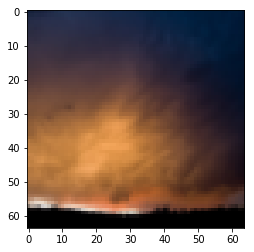

In [4]:
# Creating or Loading the Data:
X, Y, X_test, Y_test =  get_training_testing_data('../input/train_catvnoncat.h5', '../input/test_catvnoncat.h5')

# Viewing the data
# plt.scatter(X[:, 0], X[:, 1], c = Y.reshape(Y.shape[0],).tolist(), cmap=plt.cm.Spectral);
# plt.show()
print(X.shape)
print(Y.shape)

# Sanity Check:
print('training sample:', X[0], Y[0])
print('testing sample: ',X_test[0], Y_test[0])

**Creating the neural network and training it:**

0
1000
2000
3000
4000


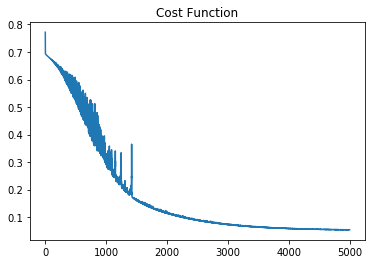

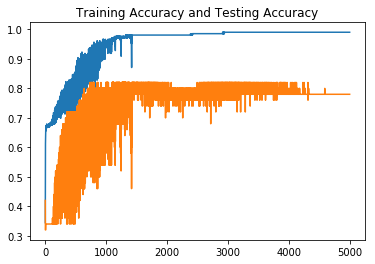

training_accuracy: 0.9904306220095693
testing_accuracy:  0.78


In [5]:

# Defining the dimensions of the neural network and constants of gradient descent
L = 4
n = {0: X.shape[1], 1: 20, 2: 7, 3: 5, 4: Y.shape[1]}
activation_fn = {1: relu, 2: relu, 3: relu, 4: sigmoid}
d_activation_fn = {1: d_relu, 2: d_relu, 3: d_relu, 4: d_sigmoid }
alpha = 0.0075
iterations = 5000
lambd = 0
# Creating the neural network
neural_network = {'L': L, 'n': n, 'W': None, 'B': None, 'activation_fn': activation_fn, 'd_activation_fn': d_activation_fn}

# Training the network:
training_accuracy = fit(neural_network, X, Y, X_test, Y_test, iterations, alpha, lambd, Verbose = True)
print('training_accuracy:', training_accuracy)

# Testing the network on Testing Data
Y_predicted = predict(neural_network, X_test)
testing_accuracy = accuracy_score(Y_predicted, Y_test)
print('testing_accuracy: ',testing_accuracy)

**Early Stopping to avoid overfitting (3000 iterations instead of 5000):**

0
1000
2000


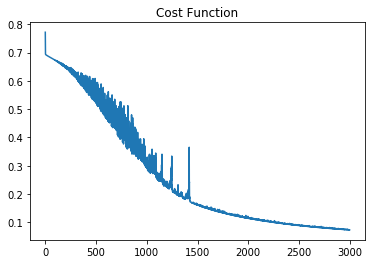

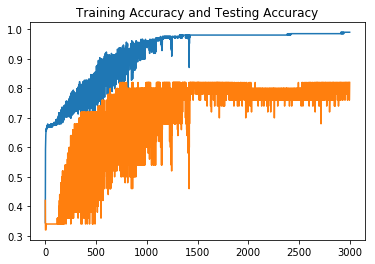

training_accuracy: 0.9904306220095693
testing_accuracy:  0.82


In [6]:
# Early stopping

# Defining the dimensions of the neural network and constants of gradient descent
L = 4
n = {0: X.shape[1], 1: 20, 2: 7, 3: 5, 4: Y.shape[1]}
activation_fn = {1: relu, 2: relu, 3: relu, 4: sigmoid}
d_activation_fn = {1: d_relu, 2: d_relu, 3: d_relu, 4: d_sigmoid }
alpha = 0.0075
iterations = 3000
lambd = 0
# Creating the neural network
neural_network = {'L': L, 'n': n, 'W': None, 'B': None, 'activation_fn': activation_fn, 'd_activation_fn': d_activation_fn}

# Training the network:
training_accuracy = fit(neural_network, X, Y, X_test, Y_test, iterations, alpha, lambd, Verbose = True)
print('training_accuracy:', training_accuracy)

# Testing the network on Testing Data
Y_predicted = predict(neural_network, X_test)
testing_accuracy = accuracy_score(Y_predicted, Y_test)
print('testing_accuracy: ',testing_accuracy)

**Regularization to avoid overfitting (lambda = 1):**

0
1000
2000
3000
4000


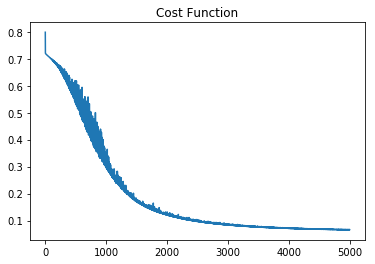

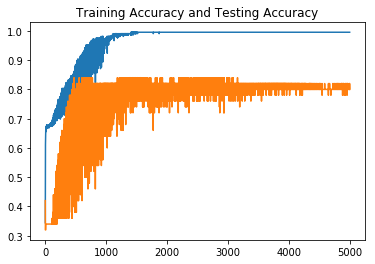

training_accuracy: 0.9952153110047847
testing_accuracy:  0.8


In [7]:
# With Regularization

# Defining the dimensions of the neural network and constants of gradient descent
L = 4
n = {0: X.shape[1], 1: 20, 2: 7, 3: 5, 4: Y.shape[1]}
activation_fn = {1: relu, 2: relu, 3: relu, 4: sigmoid}
d_activation_fn = {1: d_relu, 2: d_relu, 3: d_relu, 4: d_sigmoid }
alpha = 0.0075
iterations = 5000
lambd = 1
# Creating the neural network
neural_network = {'L': L, 'n': n, 'W': None, 'B': None, 'activation_fn': activation_fn, 'd_activation_fn': d_activation_fn}

# Training the network:
training_accuracy = fit(neural_network, X, Y, X_test, Y_test, iterations, alpha, lambd, Verbose = True)
print('training_accuracy:', training_accuracy)

# Testing the network on Testing Data
Y_predicted = predict(neural_network, X_test)
testing_accuracy = accuracy_score(Y_predicted, Y_test)
print('testing_accuracy: ',testing_accuracy)